# Mining NY Taxi Data

## Table of Content
1. Introduction
2. Data Collection
3. Data Preprocessing
4. Data Exploration
5. Travel Time Estimation
6. Demand Prediction
7. Summary & References

## 1. Introduction

The taxicabs of New York City are widely recognized icons of the city. Between 210 and 240 million people take taxis each year. New York City taxicabs transport about 600,000 people per day. There are two varieties of taxis: yellow and green. Yellow Taxis are able to pick up passengers anywhere in Manhattan, the Bronx, Queens, Brooklyn, and Staten Island. Green Taxis are able to pick up passengers in Upper Manhattan, the Bronx, Brooklyn, Queens, and Staten Island.

The New York City Taxi & Limousine Commission has released a staggeringly detailed historical dataset covering over 1.1 billion yellow and green taxi trips in the city for all of 2014 and up to June 2016. The data isn't just about the coordinates of the taxi pickup and dropoff locations, this detailed dataset further uncovers the various characteristics of the trips, including pick-up and drop-off dates and times, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.  

We want to exploit an understanding of these taxi trips, extract the stories and meaing from the trip data. And we want to utilize the data to
1. **Visualize the data effectively so that the company can make better decisions.** We will visualize demand destribution in NYC as well as destination trends from specific zones. The taxi company would maximize its earning by making suggestions for taxi where to go next while it is in service.

2. **Make travel time transparent to passengers by telling ETA (Estimated Time of Arrival) before they take a ride.** We will estimate not only a travel time, but we also try to determine uncertainty of the prediciton, which would be helpful for passengers. We are going to combine a regressior with a classfier to achieve these two tasks.

3. **Predict the demand in the future.** We will use regression models for prediciton of demand in the future.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

## 2. Data Collection
### 2.1. Taxi Dataset
The datasets we use are:
1. **New York Taxi trip data** collected and provided by the technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP).
The trip data include:
    * The yellow and green taxi trip records
    The trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. 
    * The For-Hire Vehicle (“FHV”) trip records
    These trip records include fields capturing the dispatching base license number and the pick-up date, time, and taxi zone location ID 
    * Shapefile containing the boundaries for the taxi zones
2. **Weather data** - historical hourly weather data using forceast.io provided by The Dark Sky Company


Given we have limited computational resources for this project, we reduce the size of our data by only considering the taxi trip data from **June 2016 in (or originate from) Manhattan, New York**, and the same constraint is applied to our weather data.  

### 2.2 Gather weather data

We extract the weather data using the API in weather.com.
And the columns are listed in here:
"summary","temperature","apparentTemperature", "cloudCover", "windSpeed", "humidity", "precipType", "precipProbability", "precipIntensity".
The weather data stored in: https://drive.google.com/open?id=0B9v0K-SiBfHAOExSMVFfZktOQk0

In [5]:
#pip install python-forecastio
import forecastio

# Enter your API here
api_key = "2f2f6bfbbbfeb4acd65e9342ab04658b"

lat = 40.78
lng = -73.97

attributes = ["summary","temperature","apparentTemperature", "cloudCover", "windSpeed", "humidity", "precipType", "precipProbability", "precipIntensity"]
times = []
data = {}
for attr in attributes:
    data[attr] = []

start = datetime.datetime(2016,5,30)
for offset in range(1, 32):
    forecast = forecastio.load_forecast(api_key, 'lat', lng, time=start+datetime.timedelta(offset), units="us")
    h = forecast.hourly()
    d = h.data
    for p in d:
        times.append(p.time)
        for attr in attributes:
            if attr in p.d:
                data[attr].append(p.d[attr])
            else:
                data[attr].append("")

df = pd.DataFrame(data, index=times)

df = df.tz_localize("Asia/Kolkata").tz_convert("US/Central")
df.to_csv("weather.csv")

### Weather data Example

In [6]:
print df.head()

                           apparentTemperature cloudCover  humidity  \
2016-05-30 17:30:00-05:00                72.13                 0.86   
2016-05-30 18:30:00-05:00                71.66       0.31      0.87   
2016-05-30 19:30:00-05:00                71.79       0.72      0.87   
2016-05-30 20:30:00-05:00                70.95          0      0.80   
2016-05-30 21:30:00-05:00                70.79       0.31      0.82   

                           precipIntensity  precipProbability precipType  \
2016-05-30 17:30:00-05:00              0.0                0.0              
2016-05-30 18:30:00-05:00              0.0                0.0              
2016-05-30 19:30:00-05:00              0.0                0.0              
2016-05-30 20:30:00-05:00              0.0                0.0              
2016-05-30 21:30:00-05:00              0.0                0.0              

                                 summary  temperature windSpeed  
2016-05-30 17:30:00-05:00          Clear        72

## 3. Data Preprocessing
Given we have limited computational resources for this project, we have pre-processed the dataset to only include the taxi trip data and weather data from June 2016 in Manhattan, New York. 

For this part, we need to clean the taxi data and combine the taxi data and weather data.

* In the NYC, there are two tpyes of taxi,yellow taxi and green taxi. And the attributes in these two data have a litte differences. So we need to unified the attributes first. 

* Then, for taxi bussiness, the demand in workday is very different from the demand in weekend. And the demand in daytime is very different from the demand at night. So, we extract the day and hour from the timestamp, and divide the days into 1 to 7 which means Monday to Sunday. 

* After the whole processing, there are 11 columns in the taxi data. The columns are listed in here:
'pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','trip_distance','fare_amount','tip_amount','total_amount'.

In [ ]:
#green taxi data
df = pd.read_csv('green_tripdata_2016-06.csv')
df.lpep_pickup_datetime = pd.to_datetime(pd.Series(df.lpep_pickup_datetime))
dates = pd.DatetimeIndex(df.lpep_pickup_datetime)
df['dateofmonth'] = dates.day
df['hourofday'] = dates.hour
df['dayofweek'] = df.reset_index()['lpep_pickup_datetime'].dt.dayofweek
df = df.drop(['VendorID','Extra','MTA_tax','Store_and_fwd_flag','RatecodeID','Payment_type','Tolls_amount','Improvement_surcharge'],1)
df['time'] =df.lpep_pickup_datetime.map(lambda t: t.strftime('%Y/%m/%d %H:00'))
df.time = pd.to_datetime(pd.Series(df.time))
greencolumn = ['lpep_pickup_datetime','Lpep_dropoff_datetime','Pickup_longitude','Pickup_latitude','Dropoff_longitude','Dropoff_latitude','Passenger_count','Trip_distance','Fare_amount','Tip_amount','Total_amount']
newcolumn = ['pickup_datetime','dropoff_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','trip_distance','fare_amount','tip_amount','total_amount']
df.rename(columns=dict(zip(greencolumn, newcolumn)), inplace=True)


The columns in yellow taxi data are different from the data in grean taxi, So we need to preprocess the data seperatly.And combine the two dataframe together.

In [ ]:
#yellow taxi data
yellowdf = pd.read_csv('yellow_tripdata_2016-06.csv')
yellowdf.tpep_pickup_datetime = pd.to_datetime(pd.Series(yellowdf.tpep_pickup_datetime))
dates2 = pd.DatetimeIndex(yellowdf.tpep_pickup_datetime)
yellowdf['dateofmonth'] = dates2.day
yellowdf['hourofday'] = dates2.hour
yellowdf['dayofweek'] = yellowdf.reset_index()['tpep_pickup_datetime'].dt.dayofweek
yellowdf['time'] = yellowdf.tpep_pickup_datetime.map(lambda t: t.strftime('%Y/%m/%d %H:00'))
yellowdf.time = pd.to_datetime(pd.Series(yellowdf.time))
yellowdf = yellowdf.drop(['VendorID','extra','mta_tax','store_and_fwd_flag','RatecodeID','payment_type','tolls_amount','improvement_surcharge'],1)
yellowcolumn = ['tpep_pickup_datetime','tpep_dropoff_datetime']
newyellowcolumn = ['pickup_datetime','dropoff_datetime']
yellowdf.rename(columns=dict(zip(yellowcolumn, newyellowcolumn)), inplace=True)
result = df.append([yellowdf])

Combine the taxi data with weather data by time column

In [ ]:
wdf = pd.read_csv('weather.csv')
wdf['time']= pd.to_datetime(pd.Series(wdf[wdf.columns[0]]))
wdf = wdf.drop(wdf.columns[0],axis=1)
finalresult = pd.merge(wdf, result, on='time', how='right')
finalresult.to_csv('finaldata.csv')

The final data columns are listed above.The most important feature for our model are 
* 'hourofday'
* 'dayofweek'
* 'temperature'
* 'windspeed'

In [8]:
df = pd.read_csv('/Users/guoqing/Downloads/finaldata.csv')
print df.columns

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'Unnamed: 0', u'apparentTemperature', u'cloudCover', u'humidity',
       u'precipIntensity', u'precipProbability', u'precipType', u'summary',
       u'temperature', u'windSpeed', u'time', u'pickup_datetime',
       u'dropoff_datetime', u'Store_and_fwd_flag', u'RateCodeID',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude', u'passenger_count', u'trip_distance',
       u'fare_amount', u'tip_amount', u'Tolls_amount', u'Ehail_fee',
       u'improvement_surcharge', u'total_amount', u'Payment_type',
       u'Trip_type ', u'dateofmonth', u'hourofday', u'dayofweek',
       u'actualtime'],
      dtype='object')


## 4. Data Exploration
To better understand our dataset, we did the exploratory data analysis after pre-procssing the data.

### 4.1 Data Visualizaion

The map below illustrate the distribution of both pick up and drop off coordinates of taxi trips on June 1st 2016. We use a data visualization library, folium, to show each coordinate as a marker on the map in a interactive way.

We randomly selected 1000 rows from the origirnal dataset to visualize since it would take a long time to put all the markers onto the map.

In [50]:
import folium #pip install folium
import pandas as pd
import numpy as np

coordinates = (40.78, -73.97)

df = pd.read_csv('finaldata.csv')
df = df[df['dateofmonth']==1]


data = df.take(np.random.permutation(len(df))[:1000])

### It's an interative map, after running ,the map will show up in the notebook

In [51]:
the_map = folium.Map(location=coordinates, zoom_start=12)

for index in range(len(data)):
    row = data.iloc[index,:]
    #folium.Marker([row.pickup_latitude,row.pickup_longitude], popup=str(row.pickup_datetime)).add_to(the_map)
    the_map.add_children(folium.ClickForMarker(popup=""))
    folium.CircleMarker(location=[row.pickup_latitude,row.pickup_longitude],
                     radius=20,color="red").add_to(the_map)

the_map

### Drop off

In [52]:
the_map_dropoff = folium.Map(location=coordinates, zoom_start=12)

for index in range(len(data)):
    row = data.iloc[index,:]
    #folium.Marker([row.dropoff_latitude,row.dropoff_longitude], popup=str(row.dropoff_datetime)).add_to(the_map)
    the_map_dropoff.add_children(folium.ClickForMarker(popup=""))
    folium.CircleMarker(location=[row.dropoff_latitude,row.dropoff_longitude],
                     radius=20,color="red").add_to(the_map_dropoff)

the_map_dropoff

### 4.2 Visualizing taxi zone
Next, let's load taxi zone data provided in the shapefile format and taxi rides data we preprocessed above.

In [2]:
import geopandas as gpd
import shapely
import rtree

In [3]:
df_nyc = gpd.read_file("taxi_zones/taxi_zones.shp");
df_nyc.head()

LocationID  OBJECTID  Shape_Area  Shape_Leng        borough  \
0           1         1    0.000782    0.116357            EWR   
1           2         2    0.004866    0.433470         Queens   
2           3         3    0.000314    0.084341          Bronx   
3           4         4    0.000112    0.043567      Manhattan   
4           5         5    0.000498    0.092146  Staten Island   

                                            geometry                     zone  
0  POLYGON ((933100.9183527103 192536.0856972019,...           Newark Airport  
1  (POLYGON ((1033269.243591294 172126.0078125, 1...              Jamaica Bay  
2  POLYGON ((1026308.769506663 256767.6975403726,...  Allerton/Pelham Gardens  
3  POLYGON ((992073.4667968601 203714.0759887695,...            Alphabet City  
4  POLYGON ((935843.3104932606 144283.335850656, ...            Arden Heights

/Users/odatakuma/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


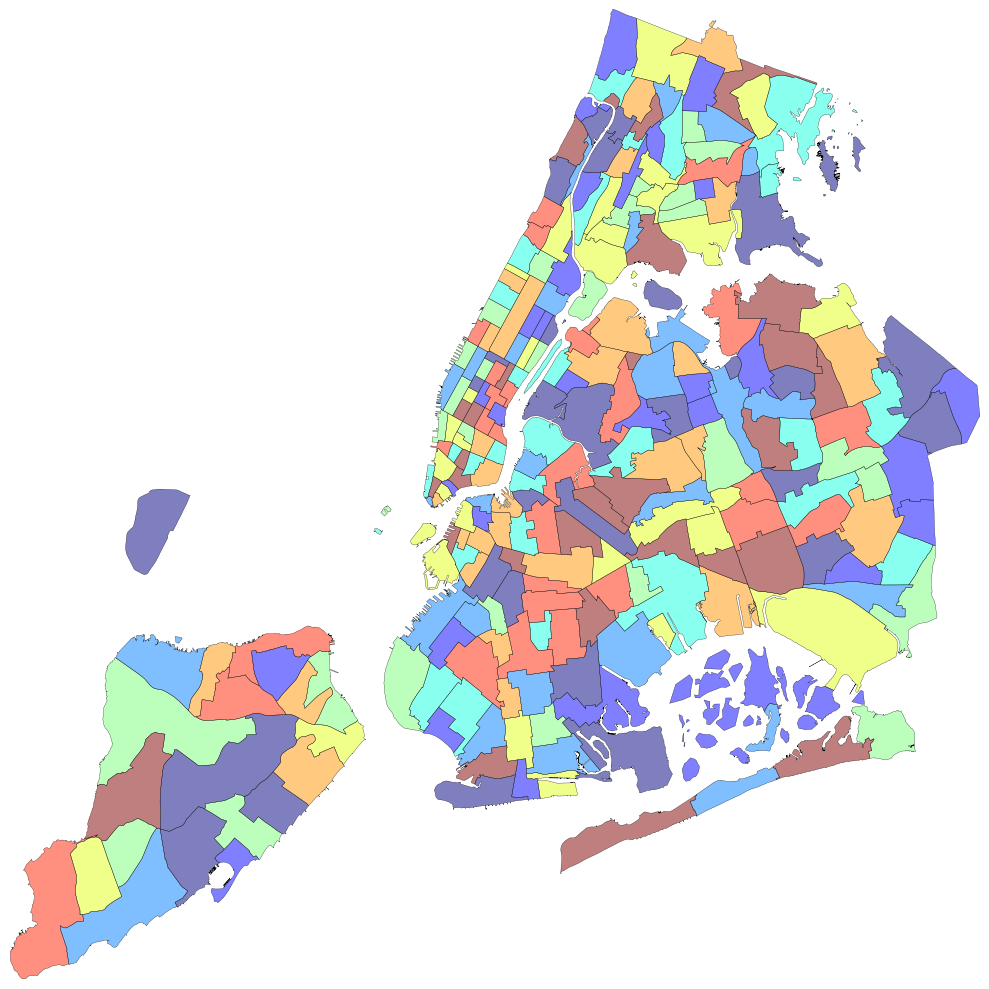

In [4]:
plt.clf()
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
ax.set_xticks([])
ax.set_yticks([])
df_nyc.plot(cmap="jet", axes=ax,linewidth=0.2)
plt.tight_layout()
plt.show();

In [5]:
df = pd.read_csv('whole_finaldata.csv', usecols=[
        u'dateofmonth',
        u'dayofweek',
        u'hourofday',
        u'pickup_latitude',
        u'pickup_longitude',
        u'dropoff_latitude',
        u'dropoff_longitude',
    ], dtype={
        'dateofmonth': np.int8,
        'dayofweek' : np.int8, 
        'hourofday' : np.int8,
        'pickup_latitude' : np.float32,
        'pickup_longitude': np.float32,
        'dropoff_latitude' : np.float32,
        'dropoff_longitude': np.float32
})

df = df.dropna()
df = df[df.pickup_latitude!=0][df.pickup_longitude!=0]
df = df[df.dropoff_latitude!=0][df.dropoff_longitude!=0]
df.info()

/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12027494 entries, 0 to 12184043
Data columns (total 7 columns):
dateofmonth          int8
dayofweek            int8
dropoff_latitude     float32
dropoff_longitude    float32
hourofday            int8
pickup_latitude      float32
pickup_longitude     float32
dtypes: float32(4), int8(3)
memory usage: 309.7 MB


### 4.3 Aggregate the trip data based on taxi zone

After we have our data ready, we then group the trip information based on the taxi zone. 
Here, we define OD_sjoin function, which conducts spacial join on both pickup (origin) and dropoff (destination) coordinates.

In [6]:
def OD_sjoin(df, gdf):
    df = gpd.GeoDataFrame(df, crs="+proj=latlon")
    df["geometry"] = [shapely.geometry.Point(loc[0], loc[1]) 
                             for loc in df[['pickup_longitude', 'pickup_latitude']].values]
    df = df[df["geometry"].apply(lambda x : x is not None)]
    df = df.to_crs(gdf.crs)
    df = gpd.sjoin(df, gdf[["geometry"]], how="inner", op="within")
    df.rename(columns={'geometry': 'pickup_geometry', 'index_right': 'pickup_zone'}, inplace=True)

    df = gpd.GeoDataFrame(df, crs="+proj=latlon")
    df["geometry"] = [shapely.geometry.Point(loc[0], loc[1]) 
                             for loc in df[['dropoff_longitude', 'dropoff_latitude']].values]
    df = df[df["geometry"].apply(lambda x : x is not None)]
    df = df.to_crs(gdf.crs)
    df = gpd.sjoin(df, gdf[["geometry"]], how="inner", op="within")
    df.rename(columns={'geometry': 'dropoff_geometry', 'index_right': 'dropoff_zone'}, inplace=True)

    return df

### 4.4 Operation trend on a given day
Let's visualize distribution of taxi demand on a given day. We first look at June 1st (Tuesday) morning (6am-10am)

In [7]:
%%time
df_day1_morning = OD_sjoin(df[df.dateofmonth==1][df.hourofday>=6] [df.hourofday<10], df_nyc)

CPU times: user 37.5 s, sys: 894 ms, total: 38.4 s
Wall time: 40.3 s


In [8]:
df_nyc['day1_morning_demand'] = df_day1_morning.groupby(['pickup_zone']).count().iloc[:,0]
df_nyc[['zone', 'borough', 'day1_morning_demand']].sort_values(by='day1_morning_demand', ascending=False).head(10)

zone    borough  day1_morning_demand
235         Upper East Side North  Manhattan                 3772
236         Upper East Side South  Manhattan                 3481
185  Penn Station/Madison Sq West  Manhattan                 3223
169                   Murray Hill  Manhattan                 2485
47                   Clinton East  Manhattan                 2428
161                  Midtown East  Manhattan                 2184
140               Lenox Hill West  Manhattan                 2164
106                      Gramercy  Manhattan                 1922
139               Lenox Hill East  Manhattan                 1814
141           Lincoln Square East  Manhattan                 1754

Thses are the top-10 zone list of pickups. Seems natural.

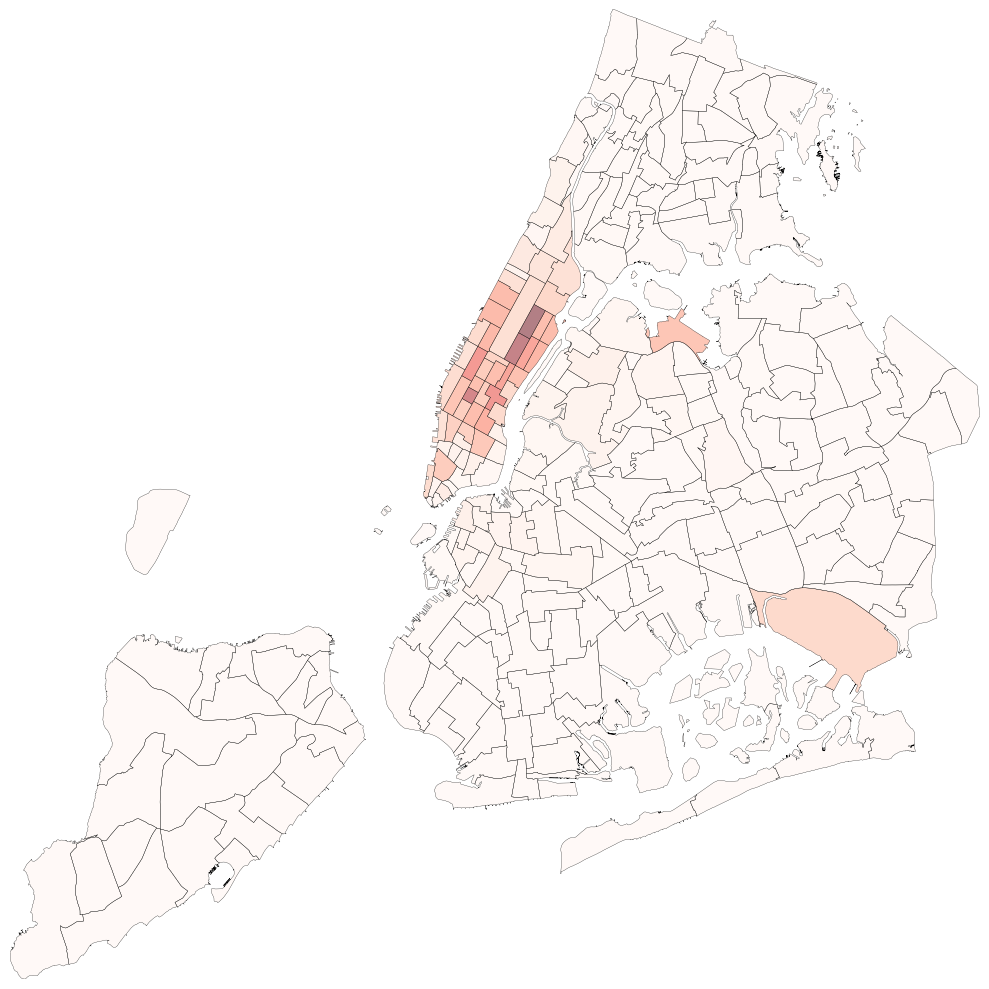

In [9]:
plt.clf()
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
ax.set_xticks([])
ax.set_yticks([])
df_nyc.plot(column='day1_morning_demand', cmap="Reds", axes=ax, linewidth=0.2)
plt.tight_layout();

We can also look at the demand from a specific zone to other zones. Let's pick up two origin zones for visualization. We will look at "Upper East Side North (235)" and "Penn Station/Madison Sq West (185)"

In [10]:
df_OD = df_day1_morning.groupby(['pickup_zone', 'dropoff_zone']).count().iloc[:,0]
df_nyc['day1_morning_zone235'] = df_OD.loc[235]
df_nyc[['zone', 'borough', 'day1_morning_zone235']].sort_values(by='day1_morning_zone235', ascending=False).head()

zone    borough  day1_morning_zone235
235  Upper East Side North  Manhattan                   441
236  Upper East Side South  Manhattan                   441
160         Midtown Center  Manhattan                   426
161           Midtown East  Manhattan                   329
74       East Harlem South  Manhattan                   162

In [11]:
df_nyc['day1_morning_zone185'] = df_OD.loc[185]
df_nyc[['zone', 'borough', 'day1_morning_zone185']].sort_values(by='day1_morning_zone185', ascending=False).head()

zone    borough  day1_morning_zone185
160             Midtown Center  Manhattan                   435
233                   Union Sq  Manhattan                   297
229  Times Sq/Theatre District  Manhattan                   236
169                Murray Hill  Manhattan                   206
161               Midtown East  Manhattan                   200

The above lists are the top-5 destinations from each zone. Let's also visualize the desitribution.

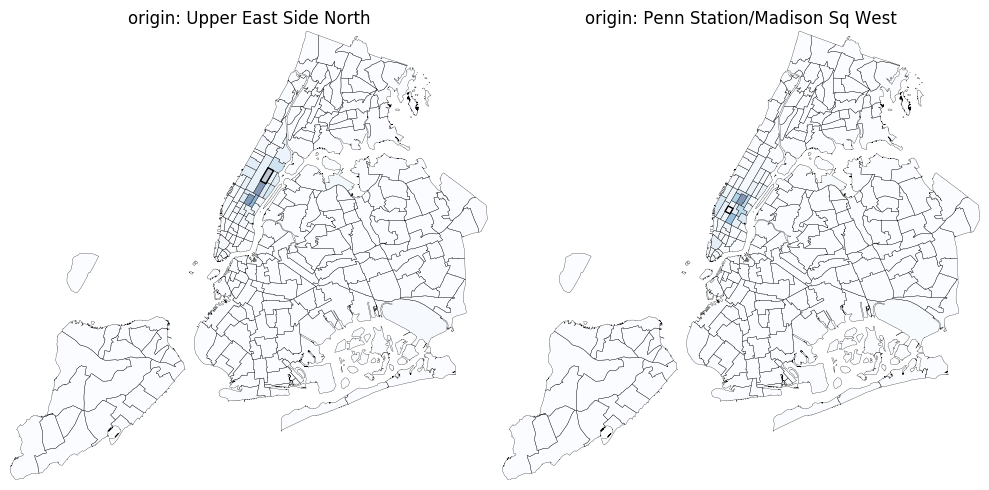

In [22]:
plt.clf()
fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = fig.add_subplot(121, axisbg='w', frame_on=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('origin: Upper East Side North')
ax2 = fig.add_subplot(122, axisbg='w', frame_on=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('origin: Penn Station/Madison Sq West')

df_nyc.plot(column='day1_morning_zone235', cmap="Blues", axes=ax1, linewidth=0.2)
df_nyc.loc[[235]].plot(column='day1_morning_zone235', cmap="Reds", axes=ax1, linewidth=1.0)
df_nyc.plot(column='day1_morning_zone185', cmap="Blues", axes=ax2, linewidth=0.2)
df_nyc.loc[[185]].plot(column='day1_morning_zone185', cmap="Reds", axes=ax2, linewidth=1.0)
plt.tight_layout();

Let's also visulize June 2nd (Wednesday) night (16-20pm) for comparison.

In [13]:
%%time
df_day2_night = OD_sjoin(df[df.dateofmonth==2][df.hourofday>=16] [df.hourofday<20], df_nyc)

CPU times: user 44.5 s, sys: 593 ms, total: 45.1 s
Wall time: 46.2 s


In [14]:
df_nyc['day2_night_demand'] = df_day2_night.groupby(['pickup_zone']).count().iloc[:,0]
df_nyc[['zone', 'borough', 'day2_night_demand']].sort_values(by='day2_night_demand', ascending=False).head(10)

zone    borough  day2_night_demand
236      Upper East Side South  Manhattan               4435
235      Upper East Side North  Manhattan               4142
160             Midtown Center  Manhattan               3189
233                   Union Sq  Manhattan               3029
161               Midtown East  Manhattan               2999
169                Murray Hill  Manhattan               2721
137          LaGuardia Airport     Queens               2677
162              Midtown North  Manhattan               2658
229  Times Sq/Theatre District  Manhattan               2552
141        Lincoln Square East  Manhattan               2504

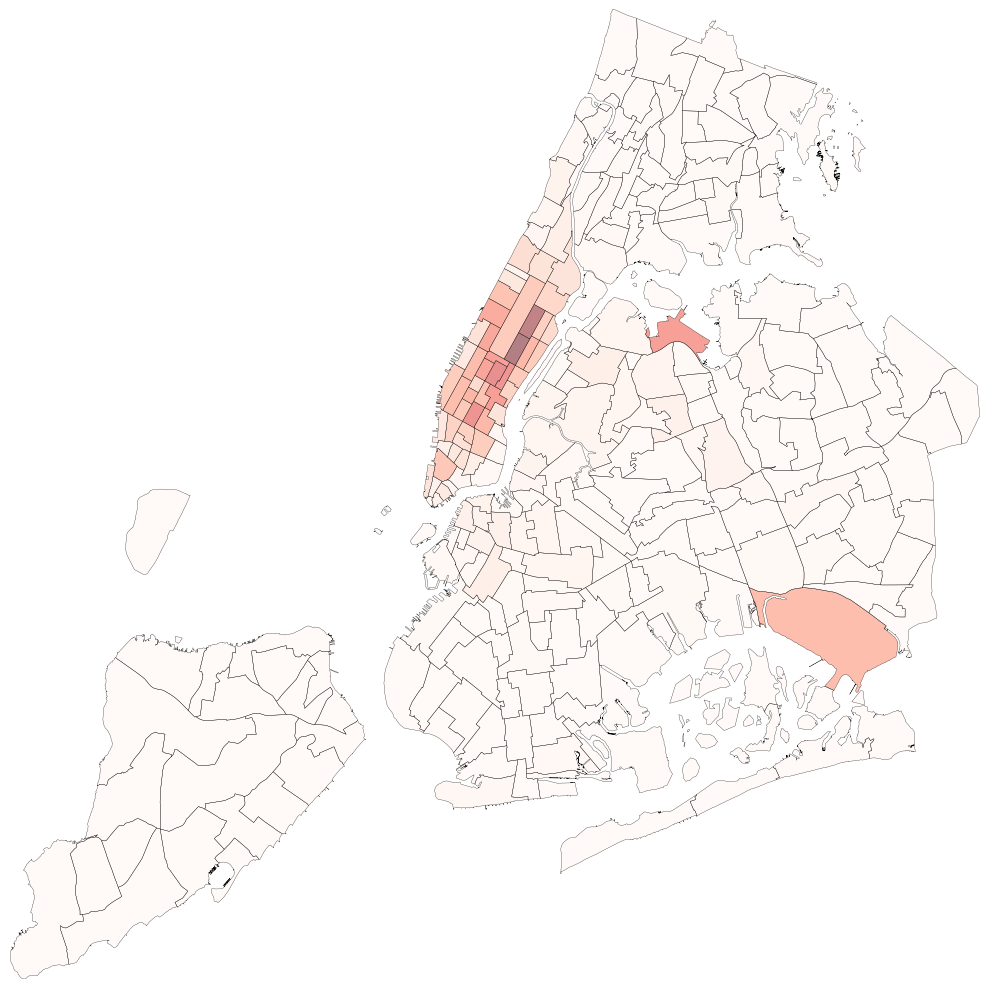

In [15]:
plt.clf()
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
ax.set_xticks([])
ax.set_yticks([])
df_nyc.plot(column='day2_night_demand', cmap="Reds", axes=ax, linewidth=0.2)
plt.tight_layout();

As you can see, in the two ariports, taxi demand is highter at night than in the morning. Let's see where passengers are heading from the two ariports.

In [16]:
df_OD = df_day2_night.groupby(['pickup_zone', 'dropoff_zone']).count().iloc[:,0]
df_nyc['day2_night_zone137'] = df_OD.loc[137]
df_nyc[['zone', 'borough', 'day2_night_zone137']].sort_values(by='day2_night_zone137', ascending=False).head()

zone    borough  day2_night_zone137
229  Times Sq/Theatre District  Manhattan                 143
161               Midtown East  Manhattan                 113
160             Midtown Center  Manhattan                  97
162              Midtown North  Manhattan                  79
169                Murray Hill  Manhattan                  63

In [17]:
df_nyc['day2_night_zone131'] = df_OD.loc[131]
df_nyc[['zone', 'borough', 'day2_night_zone131']].sort_values(by='day2_night_zone131', ascending=False).head()

zone    borough  day2_night_zone131
131                JFK Airport     Queens                 101
229  Times Sq/Theatre District  Manhattan                  89
162              Midtown North  Manhattan                  60
160             Midtown Center  Manhattan                  57
163              Midtown South  Manhattan                  52

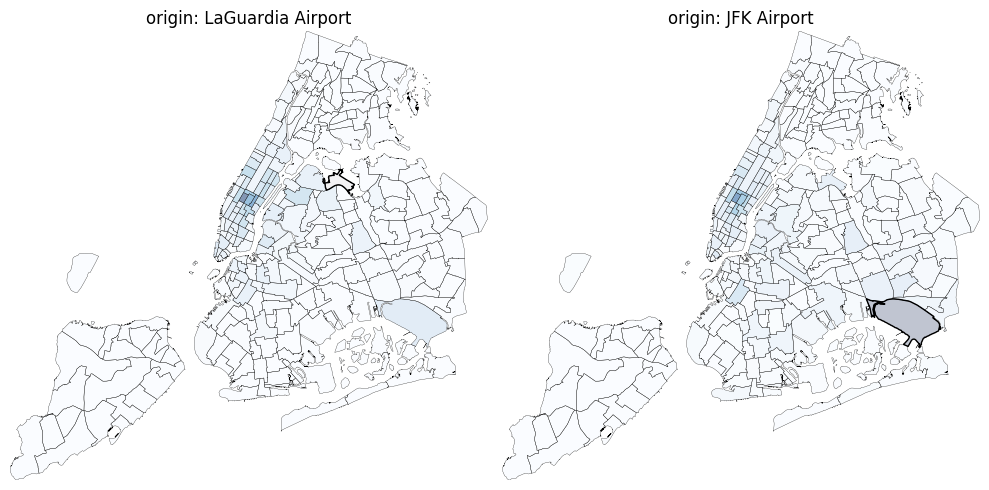

In [23]:
plt.clf()
fig = plt.figure(figsize=(10, 5), dpi=100)
ax1 = fig.add_subplot(121, axisbg='w', frame_on=False)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('origin: LaGuardia Airport')

ax2 = fig.add_subplot(122, axisbg='w', frame_on=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('origin: JFK Airport')

df_nyc.plot(column='day2_night_zone137', cmap="Blues", axes=ax1, linewidth=0.2)
df_nyc.loc[[137]].plot(column='day2_night_zone137', cmap="Reds", axes=ax1, linewidth=1.0)
df_nyc.plot(column='day2_night_zone131', cmap="Blues", axes=ax2, linewidth=0.2)
df_nyc.loc[[131]].plot(column='day2_night_zone131', cmap="Reds", axes=ax2, linewidth=1.0)
plt.tight_layout();

### 4.5 Operation trend in a week
Let's also visualize distribution of taxi demand in a week in the whole city.

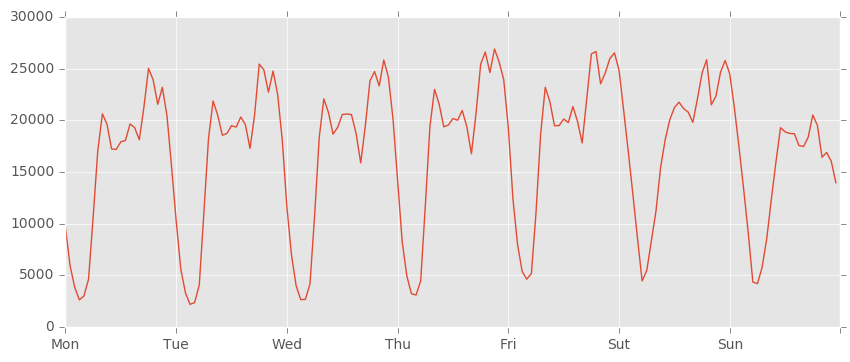

In [10]:
df_count = df.groupby(['dateofmonth', 'dayofweek', 'hourofday'])[['pickup_latitude']].count()
df_count = df_count.rename(columns={'pickup_latitude':'pickup_count'}).reset_index()
df_count = df_count.groupby(['dayofweek', 'hourofday'])['pickup_count'].mean()

plt.style.use('ggplot')
plt.figure(figsize=(10,4))
plt.plot(np.arange(df_count.shape[0]), df_count.values)
plt.xlim([0, 24*7])
plt.xticks(np.arange(0, 24*7+1, 24), 'Mon Tue Wed Thu Fri Sut Sun'.split())
plt.show()

## 5. Travel Time Estimation
### 5.1 Data Preprocessing
In this section, we are going to build ETA model for a taxi ride. First let's reload dataset necessary for travel time estimation.

In [2]:
df = pd.read_csv('whole_finaldata.csv', usecols=[
        u'dayofweek', u'hourofday',
        u'dropoff_datetime', u'dropoff_latitude', u'dropoff_longitude',
        u'pickup_datetime', u'pickup_longitude', u'pickup_latitude', u'trip_distance'
    ], dtype={
        'dayofweek' : np.int8, 
        'hourofday' : np.int8,
        'pickup_latitude' : np.float32,
        'pickup_longitude': np.float32,
        'dropoff_latitude' : np.float32,
        'dropoff_longitude': np.float32,
        'trip_distance': np.float32
    }, nrows=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12184044 entries, 0 to 12184043
Data columns (total 9 columns):
dayofweek            int8
dropoff_datetime     object
dropoff_latitude     float32
dropoff_longitude    float32
hourofday            int8
pickup_datetime      object
pickup_latitude      float32
pickup_longitude     float32
trip_distance        float32
dtypes: float32(5), int8(2), object(2)
memory usage: 534.5+ MB


There are some invalid values in the dataset. e need to clean our data. To put it simply, we will eliminate the invalid or untrustworthy values. In addition, we will compute the target trip time from pickup time and dropoff time.

In [3]:
def clean_data(df):
    df = df.dropna()
    df = df[df.pickup_latitude!=0][df.pickup_longitude!=0]
    df = df[df.dropoff_latitude!=0][df.dropoff_longitude!=0]
    df = df[df.trip_distance<300][df.trip_distance>0]
    return df

def label_trip_time(df):
    dropoff_time = df['dropoff_datetime'].str.extract(r'[\d/]+\s(?P<h>\d+):(?P<m>\d+)').astype(np.int16)
    pickup_time = df['pickup_datetime'].str.extract(r'[\d/]+\s(?P<h>\d+):(?P<m>\d+)').astype(np.int16)
    df['trip_time'] = dropoff_time.h*60+dropoff_time.m - pickup_time.h*60-pickup_time.m
    df.loc[df.index[df.trip_time<0], 'trip_time'] += 24*60
    df = df[df.trip_time>2][df.trip_time<300]
    df = df.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)
    return df

df = clean_data(df)
df = label_trip_time(df)
df.head()

/Users/odatakuma/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


dayofweek  dropoff_latitude  dropoff_longitude  hourofday  pickup_latitude  \
1          2         40.705036         -73.799751          0        40.700611   
2          2         40.700844         -73.941330          0        40.678753   
3          2         40.674641         -73.847565          0        40.699291   
6          2         40.682480         -73.995758          0        40.696163   
9          2         40.723953         -73.881569          0        40.733612   

   pickup_longitude  trip_distance  trip_time  
1        -73.807480           0.66          4  
2        -73.995644           3.80         14  
3        -73.807915           3.59         11  
6        -73.991302           1.01          3  
9        -73.869888           0.99          3

Next, we will create some features to estimate travel time. 

In [4]:
def deg2gcd(slat, slon, elat, elon):
    lat1, lon1, lat2, lon2 = map(np.deg2rad,[slat, slon, elat, elon])
    R = 6371
    x = (lon2 - lon1) * np.cos( 0.5*(lat2 + lat1) )
    y = lat2 - lat1
    d = R * np.sqrt( x*x + y*y )
    return d

def deg2bearing(slat, slon, elat, elon):
    slat, slon, elat, elon = map(np.deg2rad, [slat, slon, elat, elon])
    del_lon = elon - slon
    num = np.sin(del_lon)*np.cos(elat)
    den = np.cos(slat)*np.sin(elat) - np.sin(slat)*np.cos(elat)*np.cos(del_lon)
    return  np.arctan2(num, den)

def create_features(df):
    df['weekend'] = (df.dayofweek > 4).astype(np.int8)
    df['dayofweek_sin'] = np.sin(df.dayofweek/7.0).astype(np.float16)
    df['dayofweek_cos'] = np.cos(df.dayofweek/7.0).astype(np.float16)
    df['hour_sin'] = np.sin(df.hourofday/24.0).astype(np.float16)
    df['hour_cos'] = np.cos(df.hourofday/24.0).astype(np.float16)
    df['hour_sin2'] = df.hour_sin**2
    df['hour_cos2'] = df.hour_cos**2
    df['great_circle_km'] = deg2gcd(df.pickup_latitude, df.pickup_longitude,
                        df.dropoff_latitude, df.dropoff_longitude).astype(np.float16)
    df = df[df.great_circle_km>0][df.great_circle_km<300]
    df['bearing'] = deg2bearing(df.pickup_latitude, df.pickup_longitude,
                        df.dropoff_latitude, df.dropoff_longitude).astype(np.float16)
    return df

df = create_features(df)
df = df.dropna()
df.describe(percentiles=[.01, .25, .50, .75, .99])

dayofweek  dropoff_latitude  dropoff_longitude        hourofday  \
count  11572461.000000   11572461.000000    11572461.000000  11572461.000000   
mean          3.002617         38.210865         -67.695259        13.543860   
std           1.894924          2.671250           5.857882         6.476638   
min           0.000000         27.297945        -115.177536         0.000000   
1%            0.000000         40.644131         -74.015358         0.000000   
25%           1.000000         40.733761         -73.990829         9.000000   
50%           3.000000         40.753994         -73.978477        14.000000   
75%           5.000000         40.770226         -73.959297        19.000000   
99%           6.000000         40.846218         -73.789871        23.000000   
max           6.000000         47.157417         -51.508404        23.000000   

       pickup_latitude  pickup_longitude    trip_distance        trip_time  \
count  11572461.000000   11572461.000000  11572461.000000  11572461.000000   
mean         38.210911        -67.694809         3.090375        15.201614   
std           2.669887          5.856034         3.637624        11.983401   
min          28.109194       -115.178177         0.010000         3.000000   
1%           40.644756        -74.014328         0.400000         3.000000   
25%          40.735104        -73.991333         1.100000         7.000000   
50%          40.753330        -73.980301         1.800000        12.000000   
75%          40.768906        -73.962524         3.390000        19.000000   
99%          40.823441        -73.782433        18.690001        61.000000   
max          47.046352        -51.619411       268.190002       299.000000   

               weekend    dayofweek_sin    dayofweek_cos         hour_sin  \
count  11572461.000000  11572461.000000  11572461.000000  11572461.000000   
mean          0.263982              NaN              NaN              NaN   
std           0.440789         0.000000         0.000000         0.000000   
min           0.000000         0.000000         0.654785         0.000000   
1%            0.000000         0.000000         0.654785         0.000000   
25%           0.000000         0.142334         0.755371         0.366211   
50%           0.000000         0.415527         0.909668         0.550781   
75%           1.000000         0.655273         0.989746         0.711426   
99%           1.000000         0.755859         1.000000         0.818359   
max           1.000000         0.755859         1.000000         0.818359   

              hour_cos        hour_sin2        hour_cos2  great_circle_km  \
count  11572461.000000  11572461.000000  11572461.000000  11572461.000000   
mean               NaN              NaN              NaN              NaN   
std           0.000000         0.000000         0.000000              NaN   
min           0.574707         0.000000         0.330322         0.000380   
1%            0.574707         0.000000         0.330322         0.410400   
25%           0.702637         0.134155         0.493652         1.337891   
50%           0.834473         0.303467         0.696289         2.228516   
75%           0.930664         0.506348         0.866211         4.117188   
99%           1.000000         0.669922         1.000000        20.828125   
max           1.000000         0.669922         1.000000       299.750000   

               bearing  
count  11572461.000000  
mean               NaN  
std           0.000000  
min          -3.140625  
1%           -3.085938  
25%          -2.181641  
50%           0.135742  
75%           0.974121  
99%           3.080078  
max           3.140625

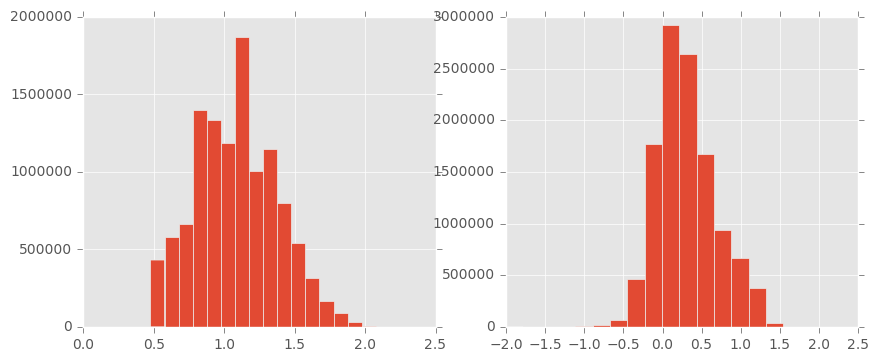

In [5]:
plt.figure(figsize=[10,4])
plt.subplot(121)
np.log10(df.trip_time).hist(bins=20)
plt.subplot(122)
np.log10(df.trip_distance).hist(bins=20);

We will split the dataset into three parts: train, validation, test.

In [6]:
from sklearn.cross_validation import train_test_split

X = df.drop(['trip_time'], axis=1).values
y = df['trip_time'].values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.3, random_state=0)
print len(X_train)
print len(X_val)
print len(X_test)

/Users/odatakuma/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


5670505
2430217
3471739


In [7]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_val = scl.transform(X_val)
X_test = scl.transform(X_test)

### 5.2 Travel Time Estimation with Regression Models
Let's experiment linear regression and gradient boosting regressor for travel time extimation.

In [8]:
%%time
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X_train, y_train)
print "Rsquare train/val: %.3f / %.3f" % (slr.score(X_train, y_train), slr.score(X_val, y_val))                           
print "MSE train/val: %.1f / %.1f" % (((y_train - slr.predict(X_train))**2).mean(), ((y_val - slr.predict(X_val))**2).mean())

Rsquare train/val: 0.646 / 0.646
MSE train/val: 50.8 / 51.0
CPU times: user 7.15 s, sys: 2.74 s, total: 9.89 s
Wall time: 9.53 s


In [9]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=1.0, n_estimators=20, subsample=0.2, max_depth=4)
gbr.fit(X_train, y_train)
print "Rsquare train/val: %.3f / %.3f" % (gbr.score(X_train, y_train), gbr.score(X_val, y_val))                           
print "MSE train/val: %.1f / %.1f" % (((y_train - gbr.predict(X_train))**2).mean(), ((y_val - gbr.predict(X_val))**2).mean())

Rsquare train/val: 0.776 / 0.772
MSE train/val: 32.1 / 32.8
CPU times: user 7min 21s, sys: 8.92 s, total: 7min 29s
Wall time: 8min 14s


Let's do some visualization to compare the two models. First, we plot the trip time predicted by each model over the real trip time. Next, we will visulaize the histogram of residue.

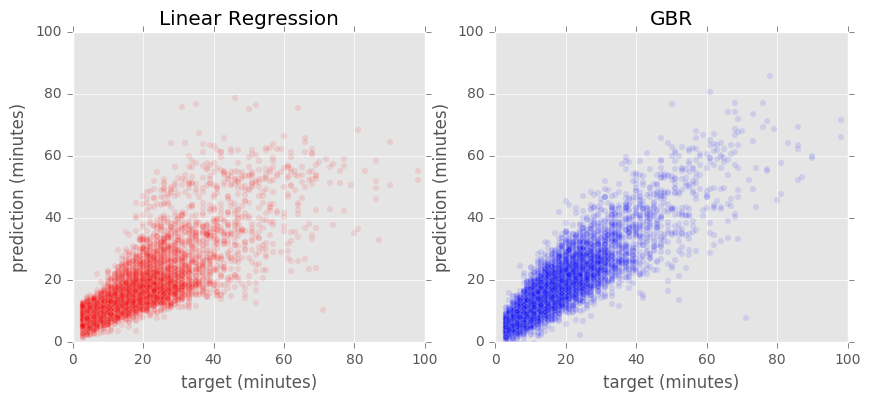

In [10]:
N = 10000
P = np.random.permutation(y_val.size)[:N]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Linear Regression')
plt.scatter(y_val[P], slr.predict(X_val[P]), alpha=0.1, c='r')
plt.xlabel('target (minutes)')
plt.xlim([0,100])
plt.ylabel('prediction (minutes)')
plt.ylim([0,100])

plt.subplot(122)
plt.title('GBR')
plt.scatter(y_val[P], gbr.predict(X_val[P]), alpha=0.1, c='b')
plt.xlabel('target (minutes)')
plt.xlim([0,100])
plt.ylabel('prediction (minutes)')
plt.ylim([0,100]);

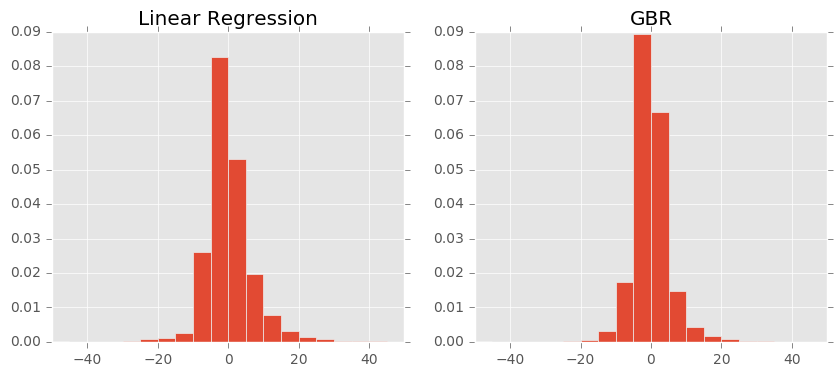

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Linear Regression')
plt.hist(y_val - slr.predict(X_val), bins=20, range=(-50, 50), normed=True)
plt.xlim([-50, 50]);

plt.subplot(122)
plt.title('GBR')
plt.hist(y_val - gbr.predict(X_val), bins=20, range=(-50, 50), normed=True)
plt.xlim([-50, 50]);

It seems that GBR is much better than linear regression while the training takes longer. We may achieve higher accuracy if we increase the number of estimators, but let's stop for now since it will take too long for training. We decide to use GBR with n_estimation=20, subsmaple=0.2, max_depth=4. Finally, let's look at the feature importances of GBR model.

In [12]:
feature_names = df.drop('trip_time', axis=1).columns
sorted(zip(feature_names, gbr.feature_importances_), key=lambda x : x[1], reverse=True)

[('trip_distance', 0.30361049579367971),
 ('great_circle_km', 0.10920921916722623),
 ('dropoff_latitude', 0.078684620221742066),
 ('hourofday', 0.073112045249173224),
 ('dropoff_longitude', 0.068525256995905892),
 ('bearing', 0.059731221593003772),
 ('pickup_longitude', 0.056514013564366569),
 ('hour_cos', 0.053667565348709111),
 ('hour_cos2', 0.051063729378963862),
 ('hour_sin2', 0.045019877895243643),
 ('pickup_latitude', 0.026646300576250198),
 ('hour_sin', 0.020703675450295632),
 ('dayofweek_sin', 0.019190020865433428),
 ('dayofweek', 0.017050863238122785),
 ('dayofweek_cos', 0.016312751181183489),
 ('weekend', 0.00095834348070026351)]

### 5.3 Predicting Uncertainty with Classification Models
While we have been built a pretty good ETA model of Gradient Boosting Regressor, you might think there is fundermental uncertainty for this task since we don't have enough information about real-time traffic and it would be "impossible" to improve the performance significantly. One other approach we can try is to predict uncertainty of the ETA. It would be useful to know how uncertain the predicted ETA is, e.g., especially when you want to take a ride to an airport for a flight.
We will build a classification model to estimate the probability of delay in ETA. Let's first create the delay label for each dataset. We will split possible continuous delays into 12 classes ranging from -20 minutes and +35 minutes.

In [13]:
def get_delay_label(delay, div=5.0, lim=[-20, 35]):
    label = np.minimum(delay, lim[1])
    label = np.maximum(label, lim[0])
    label = (np.round(label/div)*div).astype(int)
    return label

delay_train = get_delay_label(y_train - gbr.predict(X_train))
delay_val = get_delay_label(y_val - gbr.predict(X_val))
delay_test = get_delay_label(y_test - gbr.predict(X_test))

delay_scale = np.linspace(-20, 35, 12)
delay_scale

array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,
        35.])

For a classificaiton model, we will use a simple 1-hidden layer neural network using keras.

In [14]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

def MLP(input_dim, hidden_dim, output_dim, lr=0.1):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))

    sgd = SGD(lr=lr, decay=1e-7, momentum=.9)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    return model

Using TensorFlow backend.


In [15]:
n_label = 12
delay2label = {delay:i for i, delay in enumerate(delay_scale)}
label_train = np.array([delay2label[delay] for delay in delay_train])
label_val = np.array([delay2label[delay] for delay in delay_val])
label_test = np.array([delay2label[delay] for delay in delay_test])

onehot_train = np.zeros((delay_train.size, n_label))
onehot_train[np.arange(delay_train.size), label_train] = 1.0
onehot_val = np.zeros((delay_val.size, n_label))
onehot_val[np.arange(delay_val.size), label_val] = 1.0
onehot_test = np.zeros((delay_test.size, n_label))
onehot_test[np.arange(delay_test.size), label_test] = 1.0

In [16]:
mlp = MLP(X_train.shape[1], 64, n_label)
mlp.fit(X_train, onehot_train, nb_epoch=20, batch_size=1000, verbose=0,
         validation_split=0.0)

In [17]:
train_acc = (mlp.predict_classes(X_train, verbose=0) == label_train).mean()
val_acc = (mlp.predict_classes(X_val, verbose=0) == label_val).mean()
print "Accuracy train/val: %.3f / %.3f" % (train_acc, val_acc)
print "Ratio of no delay : %.3f" % (delay_train==0).mean()

Accuracy train/val: 0.516 / 0.516
Ratio of no delay : 0.512


It seems like the model is able to determined the delay correctly sometimes, which is not our primay interest though. Our main goal of this classifier is to estimate the uncertainty, which is probability of each class. So let's look at the probability of delay in some samples.

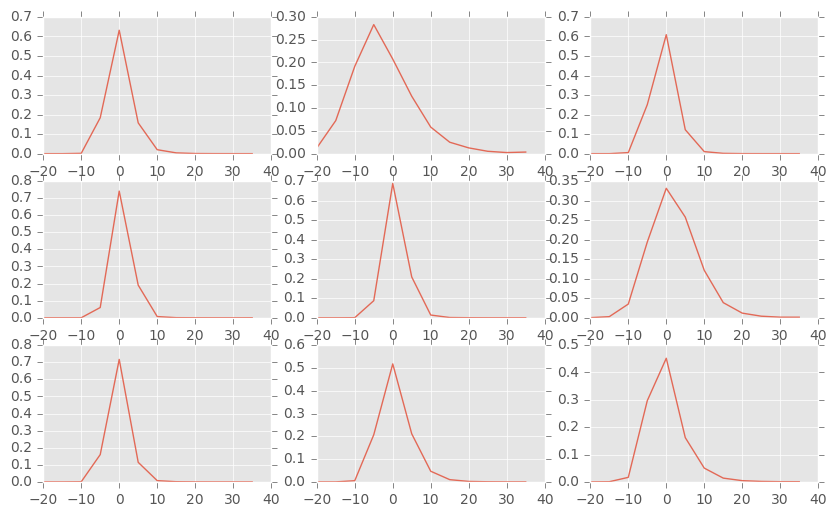

In [18]:
P = np.random.permutation(y_val.size)[:10]
p_val = mlp.predict(X_val[P], verbose=0)
plt.figure(figsize=[10,6])
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.plot(delay_scale, p_val[i], alpha=0.8);

As you can see in above graphs, the expectaion of delay is not always necessarily zero. So we may improve the prediction accuracy by adding the expetaion of delay to our ETA. Let's check our hypothisis by comparison in MSE and R square.

In [19]:
# Prediction by GBR + Expectation delay of MLP
# Training dataset
y_pred_train = gbr.predict(X_train) + np.dot(delay_scale, mlp.predict(X_train, verbose=0).T)
mse_train = ((y_pred_train - y_train)**2).mean()
Rsq_train = 1-mse_train/((y_train-y_train.mean())**2).mean()

# Validatiaon dataset
y_pred_val = gbr.predict(X_val) + np.dot(delay_scale, mlp.predict(X_val, verbose=0).T)
mse_val = ((y_pred_val - y_val)**2).mean()
Rsq_val = 1-mse_val/((y_val-y_train.mean())**2).mean()

print "Rsquare train/val: %.3f / %.3f" %(Rsq_train, Rsq_val)
print "MSE train/val: %.1f / %.1f" %(mse_train, mse_val)

Rsquare train/val: 0.786 / 0.782
MSE train/val: 30.8 / 31.5


In [20]:
# Prediction by only GBR
print "Rsquare train/val: %.3f / %.3f" % (gbr.score(X_train, y_train), gbr.score(X_val, y_val))                           
print "MSE train/val: %.1f / %.1f" % (((y_train - gbr.predict(X_train))**2).mean(), ((y_val - gbr.predict(X_val))**2).mean())

Rsquare train/val: 0.776 / 0.772
MSE train/val: 32.1 / 32.8


Looks like we could acheive better accuracy when we use the expectation of delay. Finally, let's also evaluate the performance of the combined model for the test dataset.

In [21]:
y_pred_test = gbr.predict(X_test) + np.dot(delay_scale, mlp.predict(X_test, verbose=0).T)
mse_test = ((y_pred_test - y_test)**2).mean()
Rsq_test = 1-mse_test/((y_test-y_train.mean())**2).mean()

print "Rsquare test: %.3f" %(Rsq_test)
print "MSE test: %.1f" %(mse_test)

Rsquare test: 0.784
MSE test: 30.9


### 5.4 Putting it all together
Using the two models (GBR and MLP), let's built a service like Google direction API.

In [22]:
class ETA(object):
    def __init__(self, regressor, classifier, normalizer, feature_names, delay_scale):
        self.regressor = regressor
        self.classifier = classifier
        self.normalizer = normalizer
        self.feature_names = feature_names
        self.delay_scale = delay_scale
            
    def get_features(self, origin, dest, distance, dayofweek, hourofday):
        features = pd.DataFrame(columns=self.feature_names, dtype=float)
        features.loc[0, 'dayofweek'] = dayofweek
        features.loc[0, 'dropoff_latitude'] = dest[0]
        features.loc[0, 'dropoff_longitude'] = dest[1]
        features.loc[0, 'hourofday'] = hourofday
        features.loc[0, 'pickup_latitude'] = origin[0]
        features.loc[0, 'pickup_longitude'] = origin[1]
        features.loc[0, 'trip_distance'] = distance
        features = create_features(features)
        x = self.normalizer.transform(features.values)
        return x

    def predict(self, origin, destination, distance, dayofweek, hourofday):
        x = self.get_features(origin, destination, distance, dayofweek, hourofday)
        y_pred = self.regressor.predict(x)[0]
        if self.normalizer:
            proba = self.classifier.predict_proba(x, verbose=False)[0]
        else:
            proba = self.classifier.predict_proba(x)[0]
        cdf = 0
        for i, p in enumerate(proba):
            cdf += p
            if cdf > 0.95:
                possible_delay = self.delay_scale[i]
                break
        eta_scale = y_pred + self.delay_scale
        expected_delay = np.dot(self.delay_scale, proba)
        y_pred += expected_delay
        possible_delay -= expected_delay
        return y_pred, possible_delay, proba, eta_scale

eta_model = ETA(gbr, mlp, scl, feature_names, delay_scale)

We use googlemap direction API for retrieving geocodings and route distance.

In [23]:
import json
import googlemaps
from datetime import datetime
import pytz

with open('googlemap_api.json', 'r') as f:
    api_key = json.load(f)['direction_api_key']
gmaps = googlemaps.Client(key=api_key)

def google_direction(origin, dest, gmaps):
    now = datetime.now(pytz.timezone('US/Eastern'))
    result = gmaps.directions(origin, dest, mode="driving", departure_time=now)
    direction = {}
    direction['now'] = now.strftime('%Y-%m-%d %H:%M:%S')
    direction['origin_name'] = result[0]['legs'][0]['start_address']
    direction['dest_name'] = result[0]['legs'][0]['end_address']
    loc = result[0]['legs'][0]['start_location']
    direction['origin'] = (loc['lat'], loc['lng'])
    loc = result[0]['legs'][0]['end_location']
    direction['dest'] = (loc['lat'], loc['lng'])
    direction['distance'] = result[0]['legs'][0]['distance']['value']/1000.0
    # This is an estimated trip time by google direction API
    # We don't use these values for our model
    direction['duration'] = result[0]['legs'][0]['duration']['value']/60.0
    direction['duration_in_traffic'] = result[0]['legs'][0]['duration_in_traffic']['value']/60.0
    return direction

First, let's try to estimate a short trip. We will take a ride from Grand Central Terminal to Washington Square Park. It won't take long.

In [24]:
direction = google_direction("Grand Central Terminal", "Washington Square Park NY", gmaps)
direction

{'dest': (40.7314257, -73.99701259999999),
 'dest_name': u'Washington Square Park, New York, NY 10012, USA',
 'distance': 3.136,
 'duration': 12.7,
 'duration_in_traffic': 16.083333333333332,
 'now': '2016-12-10 18:21:59',
 'origin': (40.7531155, -73.9778615),
 'origin_name': u'Grand Central Terminal, 89 E 42nd St, New York, NY 10017, USA'}

In [25]:
# import folium
# map_osm = folium.Map(location=loc_origin, zoom_start=11)
# folium.Marker(loc_origin, popup=origin).add_to(map_osm)
# folium.Marker(loc_dest, popup=dest).add_to(map_osm)
# map_osm

Google says it will take 12.7 / 14.3 minutes for this trip. Here 'duration_in_traffic' is ETA considering current traffic. Let's estimate the trip time with our ETA class.

Origin		: Grand Central Terminal, 89 E 42nd St, New York, NY 10017, USA
Destination	: Washington Square Park, New York, NY 10012, USA

ETA(minutes)
hour		 Wed 			 Sat
4	: 10 (max 16)	13 (max 17)
10	: 21 (max 35)	17 (max 27)
16	: 23 (max 38)	20 (max 35)
22	: 16 (max 26)	18 (max 28)


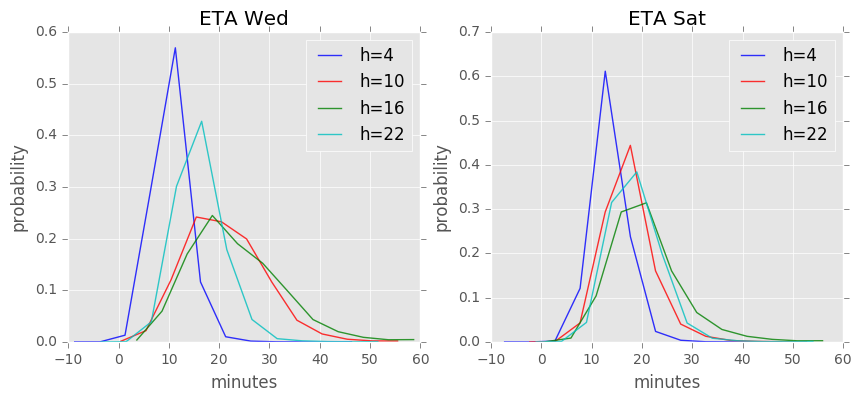

In [26]:
dayofweek_dict = {'Mon':0, 'Tue':1, 'Wed':2, 'Thu':3, 'Fri':4, 'Sat':5, 'Sun':6}
daysofweek = ['Wed', 'Sat']
hoursofday = range(4, 24, 6)
colors = 'brgcky'

plt.figure(figsize=[10,4])
etas = {}
for i, dayofweek in enumerate(daysofweek):
    plt.subplot(121+i)
    plt.title("ETA "+dayofweek)
    for j, hourofday in enumerate(hoursofday):
        eta, delay, proba, scale = eta_model.predict(
            direction['origin'], direction['dest'], direction['distance'], 
            dayofweek=dayofweek_dict[dayofweek], hourofday=hourofday)
        etas[(dayofweek, hourofday)] = (eta, eta+delay)
        plt.plot(scale, proba, c=colors[j], alpha=0.8, label="h=%d" % (hourofday))
    plt.ylabel('probability')
    plt.xlabel('minutes')
    plt.legend()

print "Origin\t\t: %s" % direction['origin_name']
print "Destination\t: %s" % direction['dest_name']
print
print "ETA(minutes)"
print "hour\t\t %s \t\t\t %s" %(daysofweek[0], daysofweek[1])
for hourofday in hoursofday:
    eta0, etamax0 = etas[(daysofweek[0], hourofday)]
    eta1, etamax1 = etas[(daysofweek[1], hourofday)]
    print "%d\t: %d (max %d)\t%d (max %d)" %(
        hourofday, eta0, etamax0, eta1, etamax1)

plt.show()

Looks like we can get reasonable results. Let's do longer trip then. We can take a taxi from New York Stock Exchange to Yankee Stadium.

In [27]:
direction = google_direction("New York Stock Exchange", "Yankee Stadium", gmaps)
direction

{'dest': (40.8259721, -73.93068459999999),
 'dest_name': u'Yankees-E. 153rd Street, Bronx, NY 10451, USA',
 'distance': 17.771,
 'duration': 23.55,
 'duration_in_traffic': 24.733333333333334,
 'now': '2016-12-10 18:22:01',
 'origin': (40.7063552, -74.0095381),
 'origin_name': u'New York Stock Exchange, New York, NY 10005, USA'}

Origin		: New York Stock Exchange, New York, NY 10005, USA
Destination	: Yankees-E. 153rd Street, Bronx, NY 10451, USA

ETA(minutes)
hour		 Wed 			 Sat
4	: 33 (max 51)	32 (max 47)
10	: 47 (max 68)	43 (max 63)
16	: 65 (max 88)	55 (max 78)
22	: 34 (max 50)	33 (max 55)


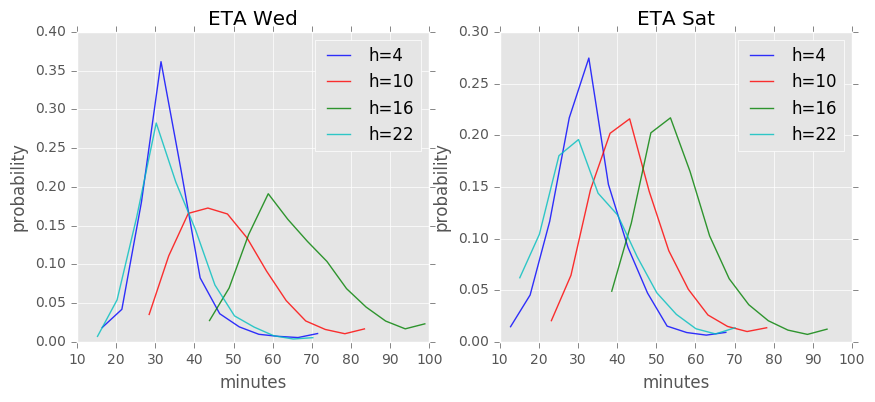

In [28]:
plt.figure(figsize=[10,4])
etas = {}
for i, dayofweek in enumerate(daysofweek):
    plt.subplot(121+i)
    plt.title("ETA "+dayofweek)
    for j, hourofday in enumerate(hoursofday):
        eta, delay, proba, scale = eta_model.predict(
            direction['origin'], direction['dest'], direction['distance'], 
            dayofweek=dayofweek_dict[dayofweek], hourofday=hourofday)
        etas[(dayofweek, hourofday)] = (eta, eta+delay)
        plt.plot(scale, proba, c=colors[j], alpha=0.8, label="h=%d" % (hourofday))
    plt.ylabel('probability')
    plt.xlabel('minutes')
    plt.legend()

print "Origin\t\t: %s" % direction['origin_name']
print "Destination\t: %s" % direction['dest_name']
print
print "ETA(minutes)"
print "hour\t\t %s \t\t\t %s" %(daysofweek[0], daysofweek[1])
for hourofday in hoursofday:
    eta0, etamax0 = etas[(daysofweek[0], hourofday)]
    eta1, etamax1 = etas[(daysofweek[1], hourofday)]
    print "%d\t: %d (max %d)\t%d (max %d)" %(
        hourofday, eta0, etamax0, eta1, etamax1)

plt.show()

## 6. Demand Prediction

#### Predictive models like these are interesting for many people, including of course the taxi companies themselves.

* Taxi companies: Companies can maximize their utilization by diverting the cabs into the locations during specific times
* Traffic planning: Planners can use the model predictions for traffic management on specific day/time/locations. The model can be enhanced in future to incorporate features like weather, holiday etc.
* Data scientists: It is interesting for data scientists to see how we have modeled location data in a simple way and yet able to get reasonably good predictions

### Preparing data for prediction
* First, Used the data we preprocced in the part 2. 

* For our prediction, we only used temperature, humidity, windspeed, dateofmonth, dayofweek, hourofday, trip_distance.

* Then,count the demand for each in the preprocced data.And make a new dataframe for Moeling

In [13]:
df = pd.read_csv('/Users/guoqing/Downloads/finaldata.csv')
names = ['actualtime','pickup_datetime','temperature','humidity','windSpeed','dateofmonth','dayofweek','hourofday',
         'dropoff_latitude','dropoff_longitude','pickup_latitude','pickup_longitude','trip_distance']
newdf = df[names]
mdf = pd.DataFrame(columns={'temperature','humidity','windSpeed','dateofmonth','num','dayofweek','hourofday','trip_distance'})
newdf['num'] = 1
mdf.num = newdf.groupby(newdf['actualtime'])['num'].sum()
for row in {'temperature','humidity','windSpeed','dateofmonth','dayofweek','hourofday','trip_distance'}:
    mdf[row] = newdf.groupby(newdf['actualtime'])[row].sum()/newdf.groupby(newdf['actualtime']).size()

mdf = mdf.dropna() 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The 'num' columns is the demand count for one hour interval

In [14]:
print mdf.head()

                     trip_distance  dayofweek  temperature  humidity  \
actualtime                                                             
2016-06-01 00:00:00       2.945947        2.0        74.53      0.72   
2016-06-01 01:00:00       2.669937        2.0        74.90      0.73   
2016-06-01 02:00:00       2.627573        2.0        72.77      0.75   
2016-06-01 03:00:00       2.863559        2.0        73.93      0.70   
2016-06-01 04:00:00       3.520483        2.0        73.23      0.73   

                     windSpeed   num  hourofday  dateofmonth  
actualtime                                                    
2016-06-01 00:00:00       8.16  1125        0.0          1.0  
2016-06-01 01:00:00       5.63   790        1.0          1.0  
2016-06-01 02:00:00       9.00   445        2.0          1.0  
2016-06-01 03:00:00       5.82   295        3.0          1.0  
2016-06-01 04:00:00       4.86   331        4.0          1.0  


### Approach 1: Predicting the pickup density for an average day of week and time of day

We trained and tested a Random Forest regressor using the preprocessed data
A taxi company could use this type of prediction on a daily basis to tune their policies based on weather or other factors to maximize coverage on a specific day.

In [57]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.cross_validation import train_test_split

#split the data to train and test
X = mdf.drop(['num'], axis=1).values
y = mdf['num'].values
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.3, random_state=0)

#random forest train and fit
rf = RandomForestRegressor(n_estimators = 50,max_depth=18)
reg=rf.fit(X_train,y_train)

#accuracy of model
training_accuracy = reg.score(X_train, y_train)
test_accuracy = reg.score(X_val, y_val)
print "############# based on standard predict ################"
print "R^2 on training data: %0.4f" % (training_accuracy)
print "R^2 on test data:     %0.4f" % (test_accuracy)

############# based on standard predict ################
R^2 on training data: 0.9894
R^2 on test data:     0.8883


In [62]:
rfpred = reg.predict(X_test)
rfpredict = rfpred.astype(int).tolist()
i = 0
monday = []
# print len(X_test),len(X_train),len(X)
# print X_test[:,-1]
for row in X_test[:,1]:
    if row == 0:
         monday.append(rfpredict[i])
    i+=1

print monday
# 24 hours prediction result for monday

[1298, 995, 1832, 1640, 2041, 2555, 2202, 1918, 1720, 519, 527, 644, 2014, 1961, 2172, 2624, 1957, 829, 1811, 1765, 2489, 2120, 2548, 1659]


### Approach 2: Predicting the pickup demand next N intervals

It's very important to do real-time prediction for taxi demand or Uber demand:
* For drivers,He/She may want to know which places will be in high demand in next serveral hours,so the driver can get there ealie.
* For passengers,it's always hard to ask a taxi or Uber in high demand palces,so it can also help them to avoid these places. And there will be more prepared for them.

So, what we need to do is to make the prediction based on larger historical data, and give our clients the demand prediction in the next N hours or next N minutes .

In [75]:
N = 5

X_train = X[1:(X.shape[0]-N),:]
X_test = X[(X.shape[0]-N):X.shape[0],:]
y_train = y[1:(y.shape[0]-N)]
y_test = y[(y.shape[0]-N):y.shape[0]]

rf = RandomForestRegressor(n_estimators = 50,max_depth=18)
reg=rf.fit(X_train,y_train)
rfpred = reg.predict(X_test)

rfpredict = rfpred.astype(int).tolist()
print rfpredict

[3002, 2682, 2410, 2406, 2427]


Because the data limitation of this project. We can not do the real-time prediction for taxi or Uber. But we proposed a method.
1.For the data part,real-time data in those companies are delivered by Kafka which recorded the binlog changes in original database(MySQL).And for the fastest query, we can use Elasticsearch for the data storage and build a SQL application on the top of it. So we can get the data with the features only with one SQL query in less than 0.1 second.
2.For the prediction,we can build a Flask server to process the data with features to make prediction for our customers. Xgboost or Random Forest is good choice.
For the Application, we can use the google map API for choosing the boundary(Polygon). And send the polygon coordinates to our backend, and Elasticsearch gives back the data in this boundary and then we process the predicton in one second, and send back the prediction result to our application.

## 7. Summary and references
This is the final project report in Practical Data Science, Fall 2016, at Carnegie Mellon University. We have demonstrated how to utilize the historical taxi data throgh building applicaitons of demand prediction and travel time prediction. We are focusing not on the algorithms of machine learning but on the practical demonstration of data science tools in this report. We hope you enjoyed reading it. Thank you for reading to the end.


For topic choosing, we believe that demand prediction is very important for pilotless future. And our team want to get closer to the new world by doing some works through this course. We learned a lot from this final project, not only the ride demand but also how to apply data science in our real world.
1. TLC trip record data: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml
